In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
import pytorch_lightning as pl
from typing import Tuple
import PIL
from PIL import Image
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import csv
from torchmetrics.functional import accuracy
import numpy as np
import torchvision
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2
from torchvision import datasets
from torchmetrics import MetricCollection, Accuracy, F1Score, Precision, Recall
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [2]:
# Fixing random state for reproducibility using NumPy
rng = np.random.RandomState(31)

# Setting the seed for NumPy to ensure reproducibility
np.random.seed(31)

# Setting the seed for PyTorch Lightning to ensure reproducibility
pl.seed_everything(31)

31

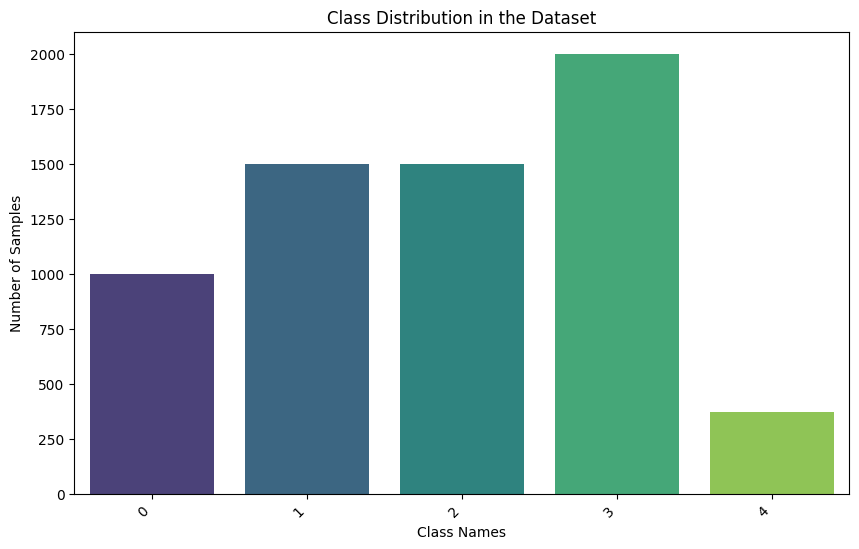

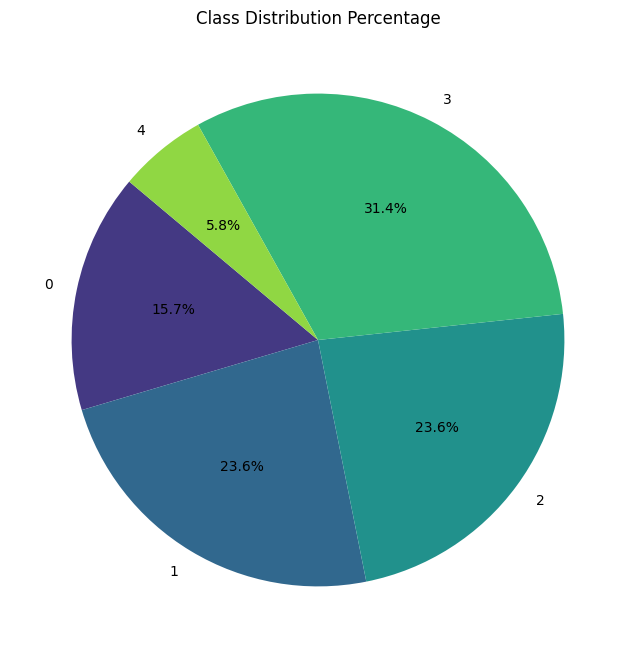

In [3]:
# Assuming you have already loaded the dataset using ImageFolder
dataset0 = datasets.ImageFolder(root="/kaggle/input/hw2-train/train", transform=None)

# Extract class names and their counts
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Plot a bar graph to show class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts, palette="viridis")
plt.title("Class Distribution in the Dataset")
plt.xlabel("Class Names")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha="right")
plt.show()

# Optionally, you can also show a pie chart for a clearer representation of proportions
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(class_names)))
plt.title("Class Distribution Percentage")
plt.show()

In [4]:
class HW2_DataModule(pl.LightningDataModule): 
    def __init__(self, train_data_dir, test_data_dir, batch_size, num_workers=4, val_split=0.2):
        super(HW2_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.test_data_dir = test_data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split

        # Initialize the custom image transformation
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #    std=[0.229, 0.224, 0.225]),
        ])

    def setup(self, stage=None):
        # Load train and validation datasets
        dataset = ImageFolder(self.train_data_dir, transform=self.transform)

        # Split the dataset into training and validation sets
        train_size = int((1.0 - self.val_split) * len(dataset))
        val_size = len(dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

        # Load the test dataset with preprocessing
        self.test_dataset = ImageFolder(self.test_data_dir, transform=self.transform)

    def train_dataloader(self):
        # Return the DataLoader for the training dataset
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        # Return the DataLoader for the validation dataset
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        # Return the DataLoader for the test dataset
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    

In [5]:
class HW2_Model(pl.LightningModule):
    def __init__(self, input_channels, num_classes):
        super(HW2_Model, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
        self.metrics = MetricCollection([
            Accuracy(task='multiclass', num_classes=num_classes),
            F1Score(task='multiclass', num_classes=num_classes),
            #Precision(task='multiclass', num_classes=num_classes),
            #Recall(task='multiclass', num_classes=num_classes)
        ])
        self.val_metrics = MetricCollection([
            Accuracy(task='multiclass', num_classes=num_classes),
            F1Score(task='multiclass', num_classes=num_classes),
            #Precision(task='multiclass', num_classes=num_classes),
            #Recall(task='multiclass', num_classes=num_classes)
        ])
        self.test_metrics = MetricCollection([
            Accuracy(task='multiclass', num_classes=num_classes),
            F1Score(task='multiclass', num_classes=num_classes),
            #Precision(task='multiclass', num_classes=num_classes),
            #Recall(task='multiclass', num_classes=num_classes)
        ])
        
        self.relu = nn.ReLU()        
        self.conv1 = nn.Conv2d(input_channels, 6, 3, 1)
        self.maxpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.maxpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        #self.conv3 = nn.Conv2d(16, 30, 3, 1)
        #self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7744, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        #self.fc4 = nn.Linear(64, 20)
        #self.fc5 = nn.Linear(20, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):        
        x = self.maxpool1(self.relu(self.conv1(x)))

        x = self.maxpool2(self.relu(self.conv2(x)))
        
        #x = self.maxpool3(self.relu(self.conv3(x)))
            
        x = self.relu(self.fc1(self.flatten(x)))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.fc4(x)
        return self.log_softmax(x)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def predict(self, obs):
        # Assuming obs is a NumPy array with shape (96, 96, 3)

        # Convert the observation to a PyTorch tensor
        obs_tensor = torch.tensor(obs, dtype=torch.float32)

        # Transpose the channels to match the expected input shape (3, 96, 96)
        obs_tensor = obs_tensor.permute(2, 0, 1)

        # Add a batch dimension to the observation
        obs_tensor = obs_tensor.unsqueeze(0)

        # Ensure the model is in evaluation mode
        self.eval()

        # Forward pass to get predictions
        with torch.no_grad():
            preds = self(obs_tensor)

        # Get the predicted class labels
        predicted_labels = torch.argmax(preds, dim=1).cpu().numpy()

        return predicted_labels
    
    
    def display_images_labels_predictions(self, images, labels, predictions):
        # Convert images to PIL format for visualization
        to_pil = ToPILImage()
        pil_images = [to_pil(image) for image in images]

        # Display images, labels, and predictions
        for i in range(len(images)):
            plt.imshow(pil_images[i])
            plt.title(f"Label: {labels[i].item()}, Prediction: {predictions[i].item()}")
            plt.show()
    
    def training_step(self, batch, batch_idx):
        images, labels = batch 
        preds = self(images)
        loss = self.loss(preds, labels)
        self.training_step_outputs.append(loss)        
        self.metrics.update(torch.argmax(preds, dim=1), labels)
        out = self.metrics(torch.argmax(preds, dim=1),labels)
        self.log_dict(out, prog_bar=True)
        self.log_dict({'train_loss':loss})
        
        return {'loss':loss, 'metrics':self.metrics}
    
    def on_training_epoch_end(self):        
                
        loss = torch.stack(self.training_step_outputs).mean()
        self.log("train_loss", loss)
        
        message = f'Epoch {self.current_epoch} Training loss -> {loss}'
        print(message)
        self.training_step_outputs.clear()  # free memory
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch 
        preds = self(images)
        
        loss = self.loss(preds, labels)
        self.validation_step_outputs.append(loss)

        # Update the metrics before computing
        self.val_metrics.update(torch.argmax(preds, dim=1), labels)

        # Compute the metrics after updating
        out = self.val_metrics.compute()

        # Log the computed metrics
        self.log_dict(out, prog_bar=True)
        self.log('val_loss', loss, prog_bar=True)
        
        return {'val_loss': loss, 'metrics': self.val_metrics}
    
    def on_validation_epoch_end(self):        
        
        loss = torch.stack(self.validation_step_outputs).mean()
        self.log("val_loss", loss)
        
        message = f'Epoch {self.current_epoch} Validation loss -> {loss}'
        print(message)
        self.validation_step_outputs.clear()  # free memory
                
    def test_step(self, batch, batch_idx):
        images, labels = batch 
        preds = self(images)
        out = self.test_metrics(torch.argmax(preds, dim=1), labels)
        self.test_metrics.update(torch.argmax(preds, dim=1), labels)
        
        loss = self.loss(preds, labels)
        self.test_step_outputs.append(loss)
        
        self.log_dict({'test_loss': loss.cpu().detach().item()}, prog_bar=True)
        self.log_dict(out, prog_bar=True)
        preds = torch.argmax(preds, dim=1)

        return preds, labels
    
    
    def on_test_epoch_end(self):   
        loss = torch.stack(self.test_step_outputs).mean()
        self.log("test_loss", loss)

        message = f'Epoch {self.current_epoch} Validation loss -> {loss}'
        print(message)
        self.test_step_outputs.clear()  # free memory
            
    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Function to calculate metrics at the end of an epoch.
    def _epoch_end(self, stage, outputs):
        
        # Combine predictions and labels from all batches in the epoch.
        predictions = torch.hstack([o["preds"] for o in outputs])
        labels = torch.vstack([o["labels"] for o in outputs]).argmax(axis=1)
        total = len(labels)
        
        # Calculate accuracy and error rate.
        accuracy = sum(predictions == labels).item() / total * 100
        error_rate = sum(predictions != labels).item() / total * 100
        
        # Log accuracy and error rate for monitoring.
        self.log_dict({f"accuracy/{stage}": accuracy, 
                       f"error_rate/{stage}": error_rate}, prog_bar=True)

In [6]:
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint
my_checkpoint_call = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints/",
    filename="Best_Model",
    monitor="MulticlassAccuracy",
    mode="min",
    save_top_k=1
)

my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", min_delta=0.001)
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)
# tb_logger = TensorBoardLogger("logs/", log_graph=True, log_images=True, log_histograms=True)


In [7]:
# Initialize the model and data module
model = HW2_Model(input_channels=3, num_classes=5)
datamodule = HW2_DataModule(train_data_dir="/kaggle/input/hw2-train/train", test_data_dir="/kaggle/input/hw2-test/test", batch_size=64)

# Create a PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=pl.loggers.TensorBoardLogger("logs/"),
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)


In [8]:
# Train the model
result = trainer.fit(model, datamodule)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation loss -> 1.5906524658203125


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation loss -> 1.146670937538147


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation loss -> 1.0965116024017334


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Validation loss -> 1.0722479820251465


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Validation loss -> 1.0428218841552734


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Validation loss -> 1.0572118759155273


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Validation loss -> 1.021994948387146


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Validation loss -> 0.9917373657226562


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Validation loss -> 0.9826642870903015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Validation loss -> 0.9644058346748352


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Validation loss -> 0.9513072967529297


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Validation loss -> 0.9501904249191284


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Validation loss -> 0.9386799931526184


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Validation loss -> 0.9304845929145813


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Validation loss -> 0.9423209428787231


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Validation loss -> 0.9064197540283203


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Validation loss -> 0.9791011810302734


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Validation loss -> 0.9429238438606262


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 Validation loss -> 1.0029038190841675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 Validation loss -> 0.9815956354141235


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 Validation loss -> 1.0557962656021118


In [9]:
best_model_path = my_checkpoint_call.best_model_path
best_model = HW2_Model.load_from_checkpoint(checkpoint_path=best_model_path, input_channels=3, num_classes=5)

In [10]:
# Test the trained model using the testing data from the DataModule.
result = trainer.test(best_model, datamodule)

Testing: |          | 0/? [00:00<?, ?it/s]

Epoch 20 Validation loss -> 1.0483726263046265


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6653328537940979     │
│     MulticlassF1Score     │    0.6653328537940979     │
│         test_loss         │    1.0483726263046265     │
└───────────────────────────┴───────────────────────────┘

In [11]:
# Specify the path where you want to save the model
model_path = f"/kaggle/working/best_model_acc_{result[0]['MulticlassAccuracy']:.5f}.pth"

# Save the model's state dict to the specified file
torch.save(best_model.state_dict(), model_path)

# To load the model later:
# Instantiate the model with the same architecture
# Replace `YourModel` with the actual class name of your model


#loaded_model = YourModel()



# Load the saved state dict into the model


#loaded_model.load_state_dict(torch.load(model_path))

# Now `loaded_model` has the same parameters as the originally saved model


pip install gym[box2d]

#import sys
#import gymnasium as gym
import gym # openAi gym
from gym import envs

#try:
#    import gymnasium as gym
#except ModuleNotFoundError:
#    print('gymnasium module not found. Try to install with')
#    print('pip install gymnasium[box2d]')
#    sys.exit(1)

import numpy as np
#from Model import HW2_Model

def play(env, model):

    seed = 2000
    obs, _ = env.reset(seed=seed)
    
    # drop initial frames
    action0 = 0
    for i in range(50):
        obs,_,_,_,_ = env.step(action0)
    
    done = False
    while not done:
        p = model.predict(obs) # adapt to your model
        action = np.argmax(p)  # adapt to your model
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated




env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'human'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# your trained
model = best_model # your trained model

play(env, model)




conda install -c conda-forge gym-box2d
